# Predicting EEG time series

Javi Rameerez <javi@rameerez.com> | [@rameerez [tw]](http://twitter.com/rameerez)

This code is Open Source, released under a GPL License.

Our goal is to use some kind of mathematical model, more concisely machine learning models, to model the behavior of our EEG time series.

Our first guess will be to use deep Recurrent Neural Networks (RNN) based on LSTM cells.

## Single-variable time series modelling with LSTM-based RNNs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv("data/3-thinking-about-moving-hands-2-BBT-E16-AAA005-2019-11-08_18-45-48/EEG.csv")

In [4]:
df.head()

,timestamp,sequence,battery,flags,EEG-ch1,EEG-ch2,EEG-ch3,EEG-ch4,EEG-ch5,EEG-ch6,EEG-ch7,EEG-ch8,EEG-ch9,EEG-ch10,EEG-ch11,EEG-ch12,EEG-ch13,EEG-ch14,EEG-ch15,EEG-ch16
0,11333317601,24377,-2,0,26244.797302,14440.732099,5991.811953,12210.174253,-45292.170747,-11380.008801,-50157.399987,-55351.558574,-7832.273439,-37863.463309,-51954.398459,-22407.896624,-35959.960986,-9194.593110,-11373.864115,-1316.946330
1,11333317601,24377,-2,0,26243.252005,14437.422485,5986.409495,12208.555949,-45295.078827,-11383.062893,-50158.568085,-55358.275143,-7834.609637,-37864.509731,-51954.921670,-22409.685276,-35960.545035,-9197.476855,-11376.346325,-1316.435287
2,11333317601,24377,-2,0,26238.092901,14432.640580,5983.099882,12203.834883,-45298.497950,-11384.973222,-50164.080052,-55362.898867,-7838.539803,-37869.315971,-51959.910426,-22412.629859,-35963.842481,-9202.429107,-11381.164733,-1318.832323
3,11333317601,24377,-2,0,26233.603021,14429.257961,5980.106628,12198.310748,-45303.377196,-11389.098071,-50169.226988,-55369.651939,-7841.472218,-37872.674256,-51965.872598,-22416.925056,-35967.152095,-9205.544038,-11385.034060,-1321.363204
4,11333317601,24377,-2,0,26235.939219,14427.140781,5978.111126,12200.598275,-45305.749897,-11390.241834,-50173.716868,-55373.229242,-7843.735409,-37874.681925,-51968.707671,-22420.599700,-35969.196268,-9208.087086,-11386.396842,-1321.886415


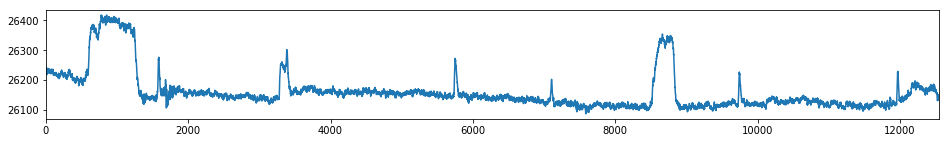

In [12]:
df["EEG-ch1"].plot(figsize=(16,2))

In [13]:
training_set = df["EEG-ch1"].values

In [14]:
training_set

array([26244.79730213, 26243.25200463, 26238.09290118, ...,
       26143.68374153, 26137.01584367, 26135.92075096])

In [18]:
# Required for Scikitlearn to rescale
training_set = training_set.reshape(-1,1)

In [19]:
training_set

array([[26244.79730213],
       [26243.25200463],
       [26238.09290118],
       ...,
       [26143.68374153],
       [26137.01584367],
       [26135.92075096]])

### Data splitting

In [20]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [21]:
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

### Defining our LSTM neural network

In [22]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

### Training the neural net

In [29]:
num_epochs = 200
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 10 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.05929
Epoch: 10, loss: 0.04702
Epoch: 20, loss: 0.04184
Epoch: 30, loss: 0.03606
Epoch: 40, loss: 0.02679
Epoch: 50, loss: 0.01190
Epoch: 60, loss: 0.00228
Epoch: 70, loss: 0.00229
Epoch: 80, loss: 0.00074
Epoch: 90, loss: 0.00084
Epoch: 100, loss: 0.00065
Epoch: 110, loss: 0.00064
Epoch: 120, loss: 0.00060
Epoch: 130, loss: 0.00058
Epoch: 140, loss: 0.00056
Epoch: 150, loss: 0.00054
Epoch: 160, loss: 0.00052
Epoch: 170, loss: 0.00051
Epoch: 180, loss: 0.00049
Epoch: 190, loss: 0.00048


In [30]:
lstm.eval()
train_predict = lstm(dataX)

In [31]:
train_predict.data.numpy()

array([[0.4944764 ],
       [0.4853824 ],
       [0.47535533],
       ...,
       [0.17787409],
       [0.18156305],
       [0.17882982]], dtype=float32)

In [32]:
dataY.data.numpy()

array([[0.4528899 ],
       [0.44567898],
       [0.43541443],
       ...,
       [0.18546043],
       [0.17394504],
       [0.15378389]], dtype=float32)

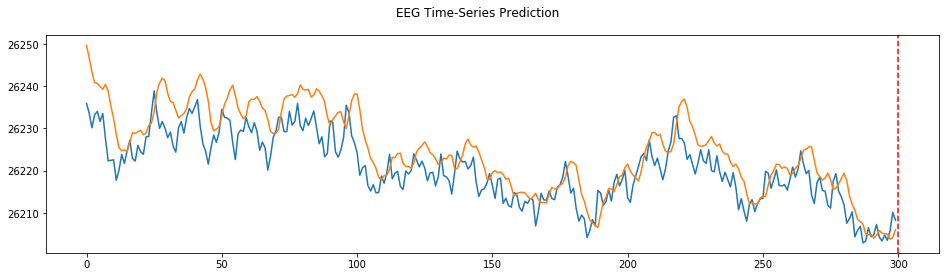

In [33]:
trim_to = 300 ## or train_size

data_predict = train_predict.data.numpy()[:trim_to]
dataY_plot = dataY.data.numpy()[:trim_to]

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(16,4))

plt.axvline(x=trim_to, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('EEG Time-Series Prediction')
plt.show()